#### Загрузка пакетов

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
!pip install xgboost

In [3]:
!pip install catboost
!pip install scikit-learn
!pip install ipywidgets
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: ok


In [4]:
!pip install hyperopt

In [5]:
pip install --user csv

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement csv
ERROR: No matching distribution found for csv


In [6]:
import numpy as np
import pandas as pd
import os
from matplotlib import pyplot as plt
%pylab inline
plt.style.use('ggplot')
import seaborn as sns

from scipy.stats import zscore
from math import isnan, isinf

from scipy.stats import spearmanr

from sklearn.neighbors import (KNeighborsClassifier, KNeighborsRegressor)
from sklearn.model_selection import (cross_val_score, cross_val_predict, 
                                     GridSearchCV, StratifiedKFold)
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import StandardScaler, scale
from sklearn.pipeline import Pipeline
from sklearn.metrics import (make_scorer, confusion_matrix, accuracy_score, precision_score, 
                            log_loss, recall_score, f1_score, classification_report,
                            roc_curve, roc_auc_score, plot_confusion_matrix)
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.base import BaseEstimator
from sklearn.ensemble import VotingClassifier, RandomForestClassifier

import xgboost as xgb
from xgboost.sklearn import XGBClassifier

import catboost
np.set_printoptions(precision=4)
from catboost import *
from catboost import datasets

import logging
import random
from concurrent.futures import ProcessPoolExecutor

Populating the interactive namespace from numpy and matplotlib


In [7]:
def print_metrics(y_true, y_pred):
    acc_score = accuracy_score(y_true, y_pred)
    conf_matrix = confusion_matrix(y_true, y_pred)
    class_report = classification_report(y_true, y_pred)
    print('Accuracy:', acc_score)
    print('-------')
    print('Confusion matrix:')
    print(conf_matrix)
    print('-------')
    print('Classification report:')
    print(class_report)

#### Загрузка данных

In [8]:
train_X = pd.read_csv('./X_train.csv')
test_X = pd.read_csv('./X_test.csv')

train_Y = pd.read_csv('./y_train.csv')
test_Y = pd.read_csv('./y_test_sample.csv')

#### Обзор данных

In [9]:
train_X.head(2)

,credit_card_utilization,age,overdue_30_59_days,debt_to_income,monthly_income,credits_loans,overdue__more_than_90_days,mortgage_loans,overdue_60_89_days,family_members
0,0.000000,56,0,0.504328,6823.894458,9,0,1,0,5.0
1,0.170659,45,1,2.405860,356.580765,5,0,0,0,0.0


In [10]:
test_X.head(2)

,index,credit_card_utilization,age,overdue_30_59_days,debt_to_income,monthly_income,credits_loans,overdue__more_than_90_days,mortgage_loans,overdue_60_89_days,family_members
0,143522,0.021069,60,0,0.184907,14403.715440,9,0,1,0,0.0
1,116747,0.009985,82,0,0.446264,6768.581963,6,0,3,0,0.0


In [11]:
train_Y.head(2)

,target
0,0
1,0


In [12]:
train_X.shape, test_X.shape

((105109, 10), (38876, 11))

In [13]:
train_Y.value_counts(normalize=True)

target
0         0.933108
1         0.066892
dtype: float64

#### Мёрдж

In [14]:
train_X['Test'] = False
test_X['Test'] = True

data = pd.concat([train_X, test_X], ignore_index=True)

In [15]:
Y = pd.concat([train_Y, test_Y], ignore_index=True)
df_inner = pd.merge(data, Y, right_index=True, left_index=True)
df_inner

,credit_card_utilization,age,overdue_30_59_days,debt_to_income,monthly_income,credits_loans,overdue__more_than_90_days,mortgage_loans,overdue_60_89_days,family_members,Test,index_x,target,index_y
0,0.000000,56,0,0.504328,6823.894458,9,0,1,0,5.0,False,NaN,0.000000,NaN
1,0.170659,45,1,2.405860,356.580765,5,0,0,0,0.0,False,NaN,0.000000,NaN
2,0.342176,75,1,0.445066,20349.895825,9,0,3,0,0.0,False,NaN,0.000000,NaN
3,0.046219,50,0,0.814508,2894.368968,12,0,1,0,3.0,False,NaN,0.000000,NaN
4,0.679556,58,0,0.390311,24833.227614,15,0,4,0,2.0,False,NaN,0.000000,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143980,0.731740,39,0,0.251005,3474.894386,5,0,0,0,0.0,True,44475.0,0.966995,44475.0
143981,0.010959,70,0,0.152539,4170.426464,14,0,1,0,0.0,True,103189.0,0.161772,103189.0
143982,0.084612,52,0,5288.053772,NaN,15,0,2,0,0.0,True,48732.0,0.077566,48732.0
143983,0.741717,51,0,0.378356,5441.458787,9,0,2,0,0.0,True,135410.0,0.671349,135410.0


In [16]:
train_X.shape, test_X.shape, data.shape, df_inner.shape

((105109, 11), (38876, 12), (143985, 12), (143985, 14))

In [17]:
df_inner.info(), df_inner.isnull().sum(), df_inner.nunique()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 143985 entries, 0 to 143984
Data columns (total 14 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   credit_card_utilization     143985 non-null  float64
 1   age                         143985 non-null  int64  
 2   overdue_30_59_days          143985 non-null  int64  
 3   debt_to_income              143985 non-null  float64
 4   monthly_income              115447 non-null  float64
 5   credits_loans               143985 non-null  int64  
 6   overdue__more_than_90_days  143985 non-null  int64  
 7   mortgage_loans              143985 non-null  int64  
 8   overdue_60_89_days          143985 non-null  int64  
 9   family_members              140225 non-null  float64
 10  Test                        143985 non-null  bool   
 11  index_x                     38876 non-null   float64
 12  target                      143985 non-null  float64
 13  index_y       

(None,
 credit_card_utilization            0
 age                                0
 overdue_30_59_days                 0
 debt_to_income                     0
 monthly_income                 28538
 credits_loans                      0
 overdue__more_than_90_days         0
 mortgage_loans                     0
 overdue_60_89_days                 0
 family_members                  3760
 Test                               0
 index_x                       105109
 target                             0
 index_y                       105109
 dtype: int64,
 credit_card_utilization       133491
 age                               88
 overdue_30_59_days                16
 debt_to_income                140025
 monthly_income                113869
 credits_loans                     59
 overdue__more_than_90_days        18
 mortgage_loans                    28
 overdue_60_89_days                13
 family_members                    13
 Test                               2
 index_x                    

In [18]:
df_inner

,credit_card_utilization,age,overdue_30_59_days,debt_to_income,monthly_income,credits_loans,overdue__more_than_90_days,mortgage_loans,overdue_60_89_days,family_members,Test,index_x,target,index_y
0,0.000000,56,0,0.504328,6823.894458,9,0,1,0,5.0,False,NaN,0.000000,NaN
1,0.170659,45,1,2.405860,356.580765,5,0,0,0,0.0,False,NaN,0.000000,NaN
2,0.342176,75,1,0.445066,20349.895825,9,0,3,0,0.0,False,NaN,0.000000,NaN
3,0.046219,50,0,0.814508,2894.368968,12,0,1,0,3.0,False,NaN,0.000000,NaN
4,0.679556,58,0,0.390311,24833.227614,15,0,4,0,2.0,False,NaN,0.000000,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143980,0.731740,39,0,0.251005,3474.894386,5,0,0,0,0.0,True,44475.0,0.966995,44475.0
143981,0.010959,70,0,0.152539,4170.426464,14,0,1,0,0.0,True,103189.0,0.161772,103189.0
143982,0.084612,52,0,5288.053772,NaN,15,0,2,0,0.0,True,48732.0,0.077566,48732.0
143983,0.741717,51,0,0.378356,5441.458787,9,0,2,0,0.0,True,135410.0,0.671349,135410.0


#### Работа с outliers и пропущенными данными

Здесь я у всех небинарных переменных довольно топорно убрал все аутлайеры превышающие порог значимости 0.05. Также довольно топорно заполнил пропуски - для месячных доходов подставил среднюю, а для членов семьи - медиану.

In [19]:
for column in df_inner.columns[:9]:
    df_inner[column] = df_inner[column].clip(df_inner[column].quantile(0.05), df_inner[column].quantile(0.95))
    
df_inner

,credit_card_utilization,age,overdue_30_59_days,debt_to_income,monthly_income,credits_loans,overdue__more_than_90_days,mortgage_loans,overdue_60_89_days,family_members,Test,index_x,target,index_y
0,0.000000,56,0,0.504328,6823.894458,9,0,1,0,5.0,False,NaN,0.000000,NaN
1,0.170659,45,1,2.405860,1267.039127,5,0,0,0,0.0,False,NaN,0.000000,NaN
2,0.342176,75,1,0.445066,14712.037107,9,0,3,0,0.0,False,NaN,0.000000,NaN
3,0.046219,50,0,0.814508,2894.368968,12,0,1,0,3.0,False,NaN,0.000000,NaN
4,0.679556,58,0,0.390311,14712.037107,15,0,3,0,2.0,False,NaN,0.000000,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143980,0.731740,39,0,0.251005,3474.894386,5,0,0,0,0.0,True,44475.0,0.966995,44475.0
143981,0.010959,70,0,0.152539,4170.426464,14,0,1,0,0.0,True,103189.0,0.161772,103189.0
143982,0.084612,52,0,2451.396833,NaN,15,0,2,0,0.0,True,48732.0,0.077566,48732.0
143983,0.741717,51,0,0.378356,5441.458787,9,0,2,0,0.0,True,135410.0,0.671349,135410.0


In [20]:
df_inner['monthly_income'] = df_inner['monthly_income'].fillna(df_inner['monthly_income'].mean())
df_inner['family_members']= df_inner['family_members'].fillna(df_inner['family_members'].median())
df_inner

,credit_card_utilization,age,overdue_30_59_days,debt_to_income,monthly_income,credits_loans,overdue__more_than_90_days,mortgage_loans,overdue_60_89_days,family_members,Test,index_x,target,index_y
0,0.000000,56,0,0.504328,6823.894458,9,0,1,0,5.0,False,NaN,0.000000,NaN
1,0.170659,45,1,2.405860,1267.039127,5,0,0,0,0.0,False,NaN,0.000000,NaN
2,0.342176,75,1,0.445066,14712.037107,9,0,3,0,0.0,False,NaN,0.000000,NaN
3,0.046219,50,0,0.814508,2894.368968,12,0,1,0,3.0,False,NaN,0.000000,NaN
4,0.679556,58,0,0.390311,14712.037107,15,0,3,0,2.0,False,NaN,0.000000,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143980,0.731740,39,0,0.251005,3474.894386,5,0,0,0,0.0,True,44475.0,0.966995,44475.0
143981,0.010959,70,0,0.152539,4170.426464,14,0,1,0,0.0,True,103189.0,0.161772,103189.0
143982,0.084612,52,0,2451.396833,6144.601025,15,0,2,0,0.0,True,48732.0,0.077566,48732.0
143983,0.741717,51,0,0.378356,5441.458787,9,0,2,0,0.0,True,135410.0,0.671349,135410.0


#### Работа с выбросами

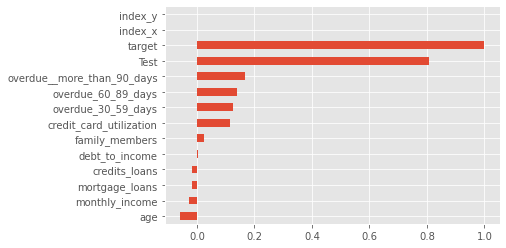

In [21]:
correl = df_inner.apply(lambda x: spearmanr(x, df_inner.target)[0])
correl.sort_values().plot.barh();

Дальше идут полученные графики распределения переменных. Некоторые распределения будут получать очень большую концентрацию наблюдений в пограничных очень высоких (малых) значения распределения величины. Это само по себе не является чем-то хорошим для результатов, но модели показывают лучший перфоманс, чем если с ними не работать.

In [22]:
df_inner.loc[df_inner['debt_to_income'] >= 5, 'debt_to_income'] = 5
df_inner['debt_to_income'] = np.log(df_inner['debt_to_income'], where=(df_inner['debt_to_income'] != 0))

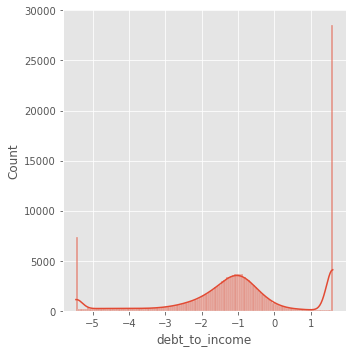

In [23]:
sns.displot(df_inner['debt_to_income'], kde=True)
sns.despine()
plt.tight_layout();

<AxesSubplot:xlabel='credits_loans', ylabel='Count'>

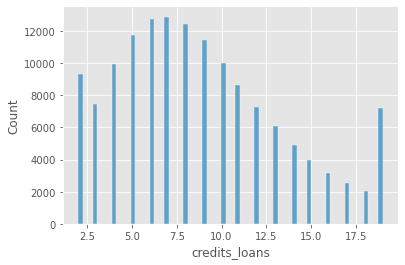

In [24]:
sns.histplot(data=df_inner, x="credits_loans")

<AxesSubplot:xlabel='family_members', ylabel='Count'>

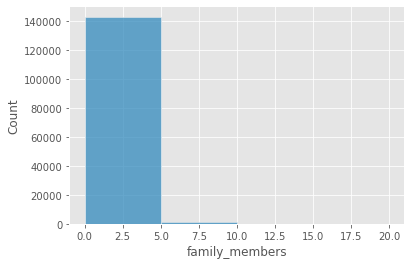

In [25]:
sns.histplot(data=df_inner, x="family_members", bins=4)

In [26]:
df_inner.loc[df_inner['monthly_income'] <= 0, 'monthly_income'] = 0
df_inner['monthly_income'] = np.log(df_inner['monthly_income'], where=(df_inner['monthly_income'] != 0))

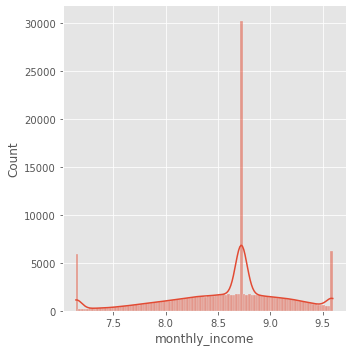

In [27]:
sns.displot(df_inner['monthly_income'], kde=True)
sns.despine()
plt.tight_layout();

In [28]:
df_inner.loc[df_inner['credit_card_utilization'] <= 0, 'credit_card_utilization'] = 0
df_inner['credit_card_utilization'] = np.log(df_inner['credit_card_utilization'], 
                                             where=(df_inner['credit_card_utilization'] != 0))

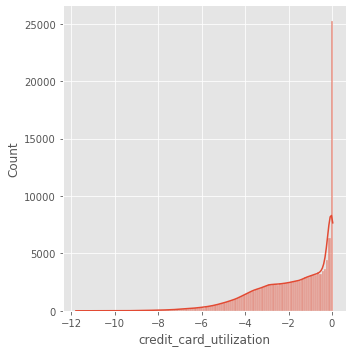

In [29]:
sns.displot(df_inner['credit_card_utilization'], kde=True)
plt.tight_layout();

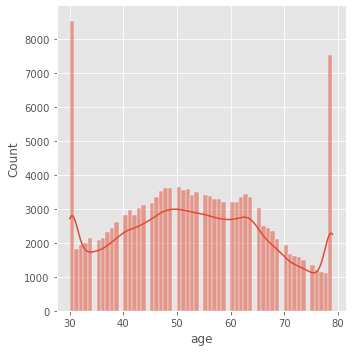

In [30]:
sns.displot(df_inner['age'], kde=True)

#### Создание рабочих датафреймов

In [31]:
df_in = df_inner 
df_in

,credit_card_utilization,age,overdue_30_59_days,debt_to_income,monthly_income,credits_loans,overdue__more_than_90_days,mortgage_loans,overdue_60_89_days,family_members,Test,index_x,target,index_y
0,0.000000,56,0,-0.684528,8.828186,9,0,1,0,5.0,False,NaN,0.000000,NaN
1,-1.768089,45,1,0.877907,7.144438,5,0,0,0,0.0,False,NaN,0.000000,NaN
2,-1.072431,75,1,-0.809533,9.596421,9,0,3,0,0.0,False,NaN,0.000000,NaN
3,-3.074363,50,0,-0.205171,7.970522,12,0,1,0,3.0,False,NaN,0.000000,NaN
4,-0.386315,58,0,-0.940810,9.596421,15,0,3,0,2.0,False,NaN,0.000000,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143980,-0.312330,39,0,-1.382282,8.153319,5,0,0,0,0.0,True,44475.0,0.966995,44475.0
143981,-4.513627,70,0,-1.880337,8.335774,14,0,1,0,0.0,True,103189.0,0.161772,103189.0
143982,-2.469684,52,0,1.609438,8.723329,15,0,2,0,0.0,True,48732.0,0.077566,48732.0
143983,-0.298788,51,0,-0.971919,8.601802,9,0,2,0,0.0,True,135410.0,0.671349,135410.0


In [32]:
df_in_B = df_in
df_in_B

,credit_card_utilization,age,overdue_30_59_days,debt_to_income,monthly_income,credits_loans,overdue__more_than_90_days,mortgage_loans,overdue_60_89_days,family_members,Test,index_x,target,index_y
0,0.000000,56,0,-0.684528,8.828186,9,0,1,0,5.0,False,NaN,0.000000,NaN
1,-1.768089,45,1,0.877907,7.144438,5,0,0,0,0.0,False,NaN,0.000000,NaN
2,-1.072431,75,1,-0.809533,9.596421,9,0,3,0,0.0,False,NaN,0.000000,NaN
3,-3.074363,50,0,-0.205171,7.970522,12,0,1,0,3.0,False,NaN,0.000000,NaN
4,-0.386315,58,0,-0.940810,9.596421,15,0,3,0,2.0,False,NaN,0.000000,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143980,-0.312330,39,0,-1.382282,8.153319,5,0,0,0,0.0,True,44475.0,0.966995,44475.0
143981,-4.513627,70,0,-1.880337,8.335774,14,0,1,0,0.0,True,103189.0,0.161772,103189.0
143982,-2.469684,52,0,1.609438,8.723329,15,0,2,0,0.0,True,48732.0,0.077566,48732.0
143983,-0.298788,51,0,-0.971919,8.601802,9,0,2,0,0.0,True,135410.0,0.671349,135410.0


In [33]:
test = df_in_B[df_in_B.Test == 1].reset_index(drop=True)
test.drop(['Test', 'index_y'], axis=1, inplace=True)
test

train = df_in_B[df_in_B.Test == 0].reset_index(drop=True)
train.drop(['Test', 'index_x', 'index_y'], axis=1, inplace=True)
train.shape
train

y = train_Y.iloc[:, 0]

tr, val, ytr, yval = train_test_split(train, train.target, test_size=0.20, random_state=42)

X = train.drop('target', axis=1)
Xtr = tr.drop('target', axis=1)
y = train['target']
Xval = val.drop('target', axis=1)

X_test = test.drop(['index_x', 'target'], axis=1)
y_test = test[['index_x', 'target']]

scaler = StandardScaler(with_mean=True, with_std=True)
Xtr_s = scaler.fit_transform(Xtr)
Xval_s = scaler.transform(Xval)

In [34]:
tr

,credit_card_utilization,age,overdue_30_59_days,debt_to_income,monthly_income,credits_loans,overdue__more_than_90_days,mortgage_loans,overdue_60_89_days,family_members,target
8639,-0.724508,58,0,-1.434747,8.729630,10,1,2,0,3.0,0.0
44234,-1.617131,70,0,-0.868872,8.077265,18,0,1,0,0.0,0.0
63216,-3.442195,54,1,-2.273431,8.629673,13,0,0,0,1.0,0.0
17773,-3.462059,76,0,-1.100403,7.144438,19,0,0,0,0.0,0.0
41856,-2.468945,53,0,-1.344177,8.588276,8,0,1,0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
54886,-3.139597,55,0,-2.012278,9.448086,13,0,1,0,2.0,0.0
76820,-1.744436,56,0,-5.014248,8.818991,5,0,0,0,3.0,0.0
103694,-0.589056,50,0,0.007706,7.490121,5,0,1,0,2.0,0.0
860,-2.382865,70,0,-1.496070,9.596421,16,0,3,0,1.0,0.0


#### Графики

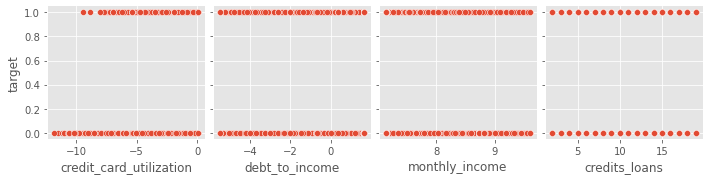

In [35]:
g = sns.pairplot(tr.assign(y=df_inner.target), y_vars=['target'],
                 x_vars=tr.loc[:, ['credit_card_utilization', 'debt_to_income', 'monthly_income', 'credits_loans']])
sns.despine();

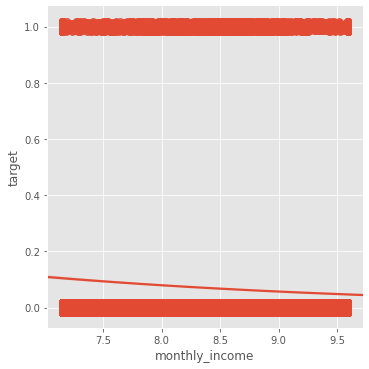

In [36]:
g = sns.lmplot(x="monthly_income", y="target", data=tr,
               y_jitter=.02, logistic=True, truncate=False)
g

Text(0.5, 1.0, 'Correlation Heatmap')

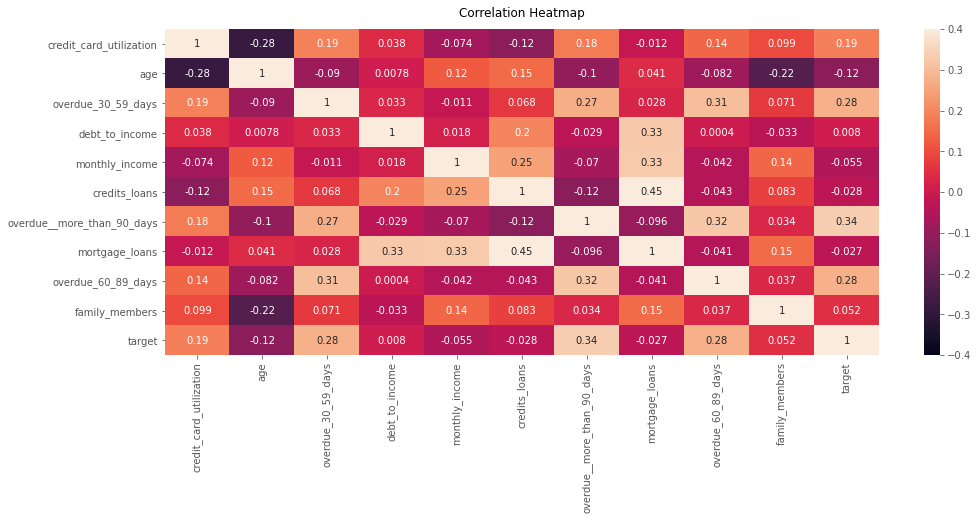

In [37]:
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(tr.corr(), vmin=-0.4, vmax=0.4, annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12)

In [38]:
tr

,credit_card_utilization,age,overdue_30_59_days,debt_to_income,monthly_income,credits_loans,overdue__more_than_90_days,mortgage_loans,overdue_60_89_days,family_members,target
8639,-0.724508,58,0,-1.434747,8.729630,10,1,2,0,3.0,0.0
44234,-1.617131,70,0,-0.868872,8.077265,18,0,1,0,0.0,0.0
63216,-3.442195,54,1,-2.273431,8.629673,13,0,0,0,1.0,0.0
17773,-3.462059,76,0,-1.100403,7.144438,19,0,0,0,0.0,0.0
41856,-2.468945,53,0,-1.344177,8.588276,8,0,1,0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
54886,-3.139597,55,0,-2.012278,9.448086,13,0,1,0,2.0,0.0
76820,-1.744436,56,0,-5.014248,8.818991,5,0,0,0,3.0,0.0
103694,-0.589056,50,0,0.007706,7.490121,5,0,1,0,2.0,0.0
860,-2.382865,70,0,-1.496070,9.596421,16,0,3,0,1.0,0.0


array([[<AxesSubplot:xlabel='credit_card_utilization', ylabel='credit_card_utilization'>,
        <AxesSubplot:xlabel='age', ylabel='credit_card_utilization'>,
        <AxesSubplot:xlabel='overdue_30_59_days', ylabel='credit_card_utilization'>,
        <AxesSubplot:xlabel='debt_to_income', ylabel='credit_card_utilization'>,
        <AxesSubplot:xlabel='monthly_income', ylabel='credit_card_utilization'>,
        <AxesSubplot:xlabel='credits_loans', ylabel='credit_card_utilization'>,
        <AxesSubplot:xlabel='overdue__more_than_90_days', ylabel='credit_card_utilization'>,
        <AxesSubplot:xlabel='mortgage_loans', ylabel='credit_card_utilization'>,
        <AxesSubplot:xlabel='overdue_60_89_days', ylabel='credit_card_utilization'>,
        <AxesSubplot:xlabel='family_members', ylabel='credit_card_utilization'>,
        <AxesSubplot:xlabel='target', ylabel='credit_card_utilization'>],
       [<AxesSubplot:xlabel='credit_card_utilization', ylabel='age'>,
        <AxesSubplot:xlabel='

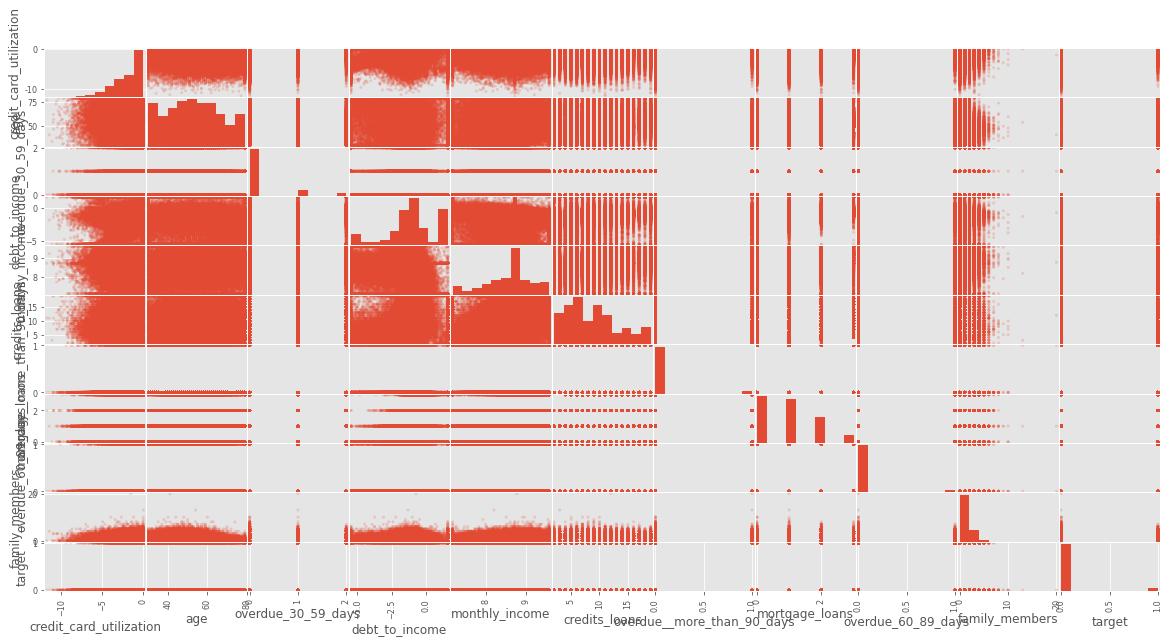

In [39]:
g = pd.plotting.scatter_matrix(tr, alpha=0.2, figsize = (20, 10))
g

## MODELS

#### Decision Tree Classifier

In [40]:
scaler = StandardScaler(with_mean=True, with_std=True)
Xtr_s = scaler.fit_transform(Xtr.loc[:, ['credit_card_utilization', 'age', 'debt_to_income', 'monthly_income']])
Xval_s = scaler.transform(Xval.loc[:, ['credit_card_utilization', 'age', 'debt_to_income', 'monthly_income']])

In [41]:
dtc = DecisionTreeClassifier(min_samples_split=3)
params = {'min_samples_split': [3,4,5,6,7,8,9,10]}
cv = StratifiedKFold(shuffle=True, n_splits=5)

In [42]:
GS_dtc = GridSearchCV(estimator=dtc, param_grid=params, cv=cv, scoring='roc_auc')

In [43]:
GS_dtc.fit(X=Xtr_s, y=ytr)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
             estimator=DecisionTreeClassifier(min_samples_split=3),
             param_grid={'min_samples_split': [3, 4, 5, 6, 7, 8, 9, 10]},
             scoring='roc_auc')

In [44]:
GS_dtc.best_score_

0.5925310780554318

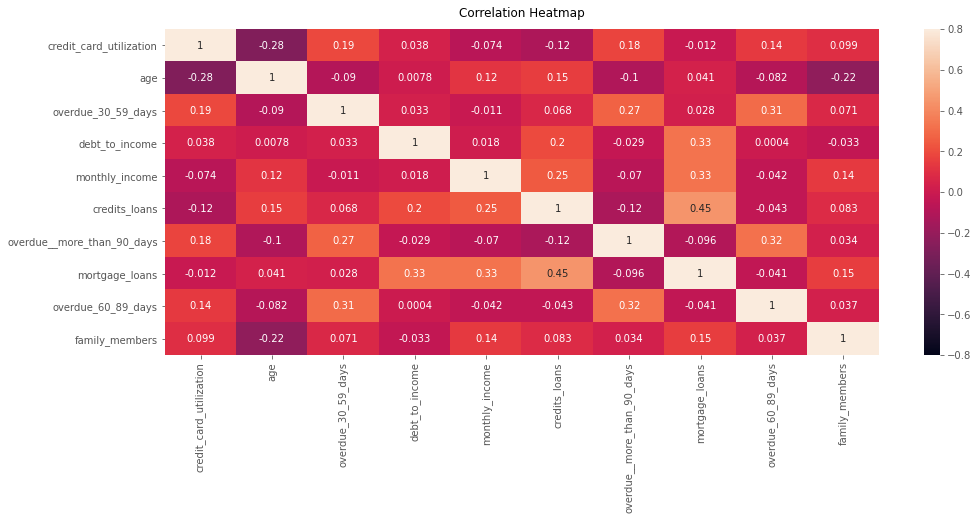

In [45]:
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(Xtr.corr(), vmin=-0.8, vmax=0.8, annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

#### Logistic Regression

In [46]:
model = LogisticRegression()
params = {'C': np.logspace(-7, 0, 20)}
GS_LR = GridSearchCV(estimator=model, param_grid=params, cv=cv, scoring='roc_auc')

In [47]:
GS_LR.fit(X=Xtr_s, y=ytr)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
             estimator=LogisticRegression(),
             param_grid={'C': array([1.0000e-07, 2.3357e-07, 5.4556e-07, 1.2743e-06, 2.9764e-06,
       6.9519e-06, 1.6238e-05, 3.7927e-05, 8.8587e-05, 2.0691e-04,
       4.8329e-04, 1.1288e-03, 2.6367e-03, 6.1585e-03, 1.4384e-02,
       3.3598e-02, 7.8476e-02, 1.8330e-01, 4.2813e-01, 1.0000e+00])},
             scoring='roc_auc')

In [48]:
GS_LR.best_params_

{'C': 1.0}

In [49]:
GS_LR.best_score_

0.7614364970350777

In [50]:
GS_LR.best_estimator_.coef_

array([[ 1.2014, -0.282 ,  0.0707, -0.082 ]])

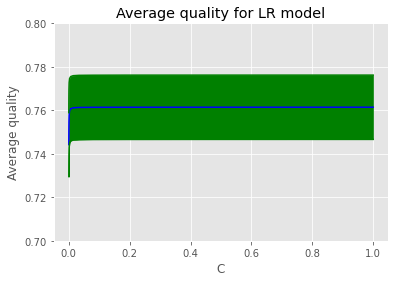

In [51]:
means = GS_LR.cv_results_['mean_test_score']
stds = GS_LR.cv_results_['std_test_score']
error = 1.95 * stds
plt.plot(params['C'], means, color = 'blue')
plt.plot(params['C'], means - error, color = 'green')
plt.plot(params['C'], means + error, color = 'green')
plt.fill_between(params['C'], means - error, means + error, color = 'green')
plt.xlabel('C')
plt.ylabel('Average quality')
plt.title('Average quality for LR model')
plt.ylim((0.7,0.8))
plt.show()

#### kNN

In [52]:
model = KNeighborsClassifier()
params = {'n_neighbors': range(1,100, 5)}
cv = StratifiedKFold(shuffle=True, n_splits=5)
GS_kNN = GridSearchCV(estimator=model, param_grid=params, cv=cv, scoring='roc_auc')

In [53]:
GS_kNN.fit(X=Xtr_s, y=ytr)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
             estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': range(1, 100, 5)}, scoring='roc_auc')

In [54]:
GS_kNN.best_params_

{'n_neighbors': 96}

In [55]:
GS_kNN.best_score_

0.7630710812598023

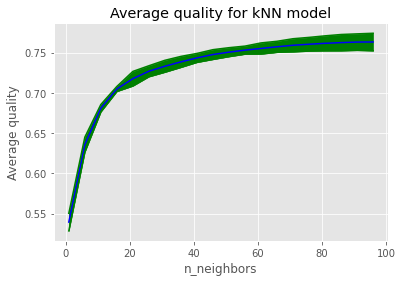

In [56]:
means = GS_kNN.cv_results_['mean_test_score']
stds = GS_kNN.cv_results_['std_test_score']
error = 1.95 * stds
plt.plot(params['n_neighbors'], means, color = 'blue')
plt.plot(params['n_neighbors'], means - error, color = 'green')
plt.plot(params['n_neighbors'], means + error, color = 'green')
plt.fill_between(params['n_neighbors'], means - error, means + error, color = 'green')
plt.xlabel('n_neighbors')
plt.ylabel('Average quality')
plt.title('Average quality for kNN model')
plt.show()

In [57]:
kNN_model = GS_kNN.best_estimator_ 
LR_model = GS_LR.best_estimator_
DT_model = GS_dtc.best_estimator_

### Random Forest

In [59]:
forest = RandomForestClassifier()
forest.fit(Xtr_s, ytr)

train_pred = forest.predict(Xtr_s)

print_metrics(ytr, train_pred)

Accuracy: 0.997050673706994
-------
Confusion matrix:
[[78440    10]
 [  238  5399]]
-------
Classification report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     78450
         1.0       1.00      0.96      0.98      5637

    accuracy                           1.00     84087
   macro avg       1.00      0.98      0.99     84087
weighted avg       1.00      1.00      1.00     84087



In [60]:
val_pred = forest.predict(Xval_s)

print_metrics(yval, val_pred)

Accuracy: 0.9276472267148701
-------
Confusion matrix:
[[19463   165]
 [ 1356    38]]
-------
Classification report:
              precision    recall  f1-score   support

         0.0       0.93      0.99      0.96     19628
         1.0       0.19      0.03      0.05      1394

    accuracy                           0.93     21022
   macro avg       0.56      0.51      0.50     21022
weighted avg       0.89      0.93      0.90     21022



In [61]:
params = {'n_estimators': [10, 100],
          'max_depth': [20, 25],
         'min_samples_split': [3,4,5,6,7,8,9,10]}

grid_forest = GridSearchCV(forest, params, cv=5, n_jobs=-1)

grid_forest.fit(Xtr_s, ytr)

GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [20, 25],
                         'min_samples_split': [3, 4, 5, 6, 7, 8, 9, 10],
                         'n_estimators': [10, 100]})

In [62]:
print('Best score:', grid_forest.best_score_)
print('Best params:', grid_forest.best_params_)

Best score: 0.932260638014075
Best params: {'max_depth': 20, 'min_samples_split': 10, 'n_estimators': 100}


In [63]:
y_pred = grid_forest.predict(Xtr_s)
print_metrics(ytr, y_pred)

Accuracy: 0.9401928954535184
-------
Confusion matrix:
[[78448     2]
 [ 5027   610]]
-------
Classification report:
              precision    recall  f1-score   support

         0.0       0.94      1.00      0.97     78450
         1.0       1.00      0.11      0.20      5637

    accuracy                           0.94     84087
   macro avg       0.97      0.55      0.58     84087
weighted avg       0.94      0.94      0.92     84087



In [64]:
y_pred = grid_forest.predict(Xval_s)
print_metrics(yval, y_pred)

Accuracy: 0.9332128246598801
-------
Confusion matrix:
[[19614    14]
 [ 1390     4]]
-------
Classification report:
              precision    recall  f1-score   support

         0.0       0.93      1.00      0.97     19628
         1.0       0.22      0.00      0.01      1394

    accuracy                           0.93     21022
   macro avg       0.58      0.50      0.49     21022
weighted avg       0.89      0.93      0.90     21022



In [65]:
print('AUC Score (Test): %f' % roc_auc_score(yval, val_pred))

AUC Score (Test): 0.509427


### XGBoost

Основная модель бустинга будет XGBoost. Выбрали этот алгоритм из-за того, что имеем много гиперпараметров, которые можем регулизировать, и он в принципе подходит под особенности нашей задачи. Нам не нужно много методов, связанных с категориальными признаками, которые можно реализовать в CatBoost. А также нам не очень нужна скорость LightGBM. Попытаемся добиться большей точности тут.

In [66]:
test = df_in_B[df_in_B.Test == 1].reset_index(drop=True)
test.drop(['Test', 'index_y'], axis=1, inplace=True)
test

train = df_in_B[df_in_B.Test == 0].reset_index(drop=True)
train.drop(['Test', 'index_x', 'index_y'], axis=1, inplace=True)
train.shape
train

y = train_Y.iloc[:, 0]

tr, val, ytr, yval = train_test_split(train, train.target, test_size=0.20, random_state=42)

X = train.drop('target', axis=1)
Xtr = tr.drop('target', axis=1)
y = train['target']
Xval = val.drop('target', axis=1)

X_test = test.drop(['index_x', 'target'], axis=1)
y_test = test[['index_x', 'target']]

scaler = StandardScaler(with_mean=True, with_std=True)
Xtr_s = scaler.fit_transform(Xtr)
Xval_s = scaler.transform(Xval)

In [67]:
xgb1 = XGBClassifier(learning_rate = 0.1, n_estimators = 150,
                     objective = 'binary:logistic', nthread = 4,
                     scale_pos_weight = 1, seed = 42)

In [68]:
target = 'target'
index = 'index_x'

In [69]:
from sklearn.metrics import accuracy_score

def modelfit(alg, dtrain, dtest, predictors, useTrainCV=True, cv_folds=5, \
             early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
        xgtest = xgb.DMatrix(dtest[predictors].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    alg.fit(dtrain[predictors], dtrain['target'],eval_metric='auc')
        
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
        
    print("\nModel Report")
    print("Accuracy : %.4g" % accuracy_score(dtrain['target'].values, dtrain_predictions))
    print("AUC Score (Train): %f" % roc_auc_score(dtrain['target'], dtrain_predprob))
    
    dtest['predprob'] = alg.predict_proba(dtest[predictors])[:,1]
    print('AUC Score (Test): %f' % roc_auc_score(dtest['target'], dtest['predprob']))
                
    feat_imp = pd.Series(alg.get_booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')


Model Report
Accuracy : 0.942
AUC Score (Train): 0.887577
AUC Score (Test): 0.862705


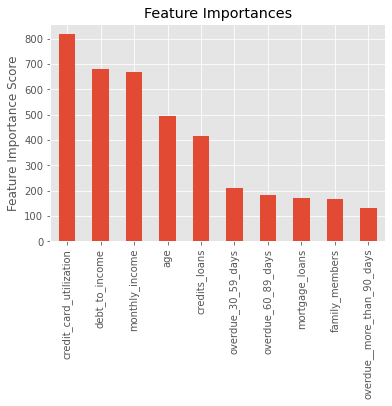

In [70]:
predictors = [x for x in tr.columns if x not in [target]]
xgb1 = XGBClassifier(
        learning_rate=0.1,
        n_estimators=150,
        objective= 'binary:logistic',
        nthread=4,
        scale_pos_weight=1,
        seed=42)
modelfit(xgb1, tr, val, predictors)

In [71]:
param_test1 = {'max_depth':range(3,10), 'min_child_weight':range(1,6)}
gsearch1 = GridSearchCV(estimator = XGBClassifier(learning_rate=0.1, n_estimators=150,
                                        objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=42), 
                       param_grid = param_test1, scoring='roc_auc',n_jobs=4, cv=5)
gsearch1.fit(tr[predictors], tr[target])

[11:46:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     enable_categorical=False, gamma=None,
                                     gpu_id=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=0.1, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=150, n_jobs=None, nthread=4,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, scale_

In [72]:
gsearch1.best_params_, gsearch1.best_score_

({'max_depth': 3, 'min_child_weight': 4}, 0.859917206956269)

In [73]:
param_test2 = {'max_depth':[2,3,4], 'min_child_weight':[3,4,5]}
gsearch2 = GridSearchCV(estimator = XGBClassifier( learning_rate=0.1, n_estimators=150, 
                                        objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=42), 
                       param_grid = param_test2, scoring='roc_auc',n_jobs=4, cv=5)
gsearch2.fit(tr[predictors], tr[target])

[11:46:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     enable_categorical=False, gamma=None,
                                     gpu_id=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=0.1, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=150, n_jobs=None, nthread=4,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, scale_

In [74]:
gsearch2.best_params_, gsearch2.best_score_

({'max_depth': 3, 'min_child_weight': 4}, 0.859917206956269)

In [75]:
param_test2b = {'min_child_weight':[3,4,5]}
gsearch2b = GridSearchCV(estimator = XGBClassifier( learning_rate=0.1, n_estimators=150, max_depth=3,
                                        objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
                       param_grid = param_test2b, scoring='roc_auc',n_jobs=4, cv=5)
gsearch2b.fit(tr[predictors], tr[target])

[11:46:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     enable_categorical=False, gamma=None,
                                     gpu_id=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=0.1, max_delta_step=None,
                                     max_depth=3, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=150, n_jobs=None, nthread=4,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, scale_pos

In [76]:
gsearch2b.best_params_, gsearch2b.best_score_

({'min_child_weight': 4}, 0.859917206956269)

In [77]:
param_test3 = {'gamma': [i/10.0 for i in range(0,10)]}
gsearch3b = GridSearchCV(estimator = XGBClassifier( learning_rate=0.1, n_estimators=150, max_depth=3, min_child_weight = 4,
                                        objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=42), 
                       param_grid = param_test3, scoring='roc_auc', n_jobs=4, cv=5)
gsearch3b.fit(tr[predictors], tr[target])

[11:47:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     enable_categorical=False, gamma=None,
                                     gpu_id=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=0.1, max_delta_step=None,
                                     max_depth=3, min_child_weight=4,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=150, n_jobs=None, nthread=4,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, scale_pos_we

In [78]:
gsearch3b.best_params_, gsearch3b.best_score_

({'gamma': 0.6}, 0.8601078311432868)


Model Report
Accuracy : 0.9372
AUC Score (Train): 0.870656
AUC Score (Test): 0.864504


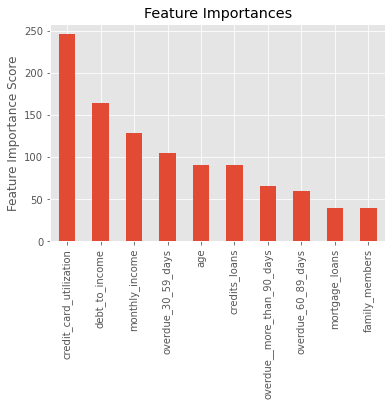

In [79]:
predictors = [x for x in tr.columns if x not in [target]]
xgb2 = XGBClassifier(
        learning_rate =0.1,
        n_estimators=150,
        max_depth=3,
        min_child_weight=4,
        gamma = 0.6,
        objective= 'binary:logistic',
        nthread=4,
        scale_pos_weight=1,
        seed=27)
modelfit(xgb2, tr, val, predictors)

In [80]:
param_test4 = {'subsample': [0.6,0.7,0.8,0.9,1.], 'colsample_bytree': [0.6,0.7,0.8,0.9,1.]}
gsearch4 = GridSearchCV(estimator = XGBClassifier( learning_rate=0.1, n_estimators=150, max_depth=3,
                                                   min_child_weight = 4, gamma = 0.6,
                                        objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=42), 
                       param_grid = param_test4, scoring='roc_auc', n_jobs=4, cv=5)
gsearch4.fit(tr[predictors], tr[target])

[11:49:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     enable_categorical=False, gamma=0.6,
                                     gpu_id=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=0.1, max_delta_step=None,
                                     max_depth=3, min_child_weight=4,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=150, n_jobs=None, nthread=4,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, scale_pos_wei

In [81]:
gsearch4.best_params_, gsearch4.best_score_

({'colsample_bytree': 0.8, 'subsample': 0.6}, 0.8606373498179082)

In [82]:
param_test5 = {'reg_alpha': [1e-5, 1e-2, 0.1, 1, 100]}
gsearch5 = GridSearchCV(estimator = XGBClassifier(learning_rate=0.1, n_estimators=150, max_depth=3,
                                                   min_child_weight = 4, gamma = 0.6,
                                                  subsample = 0.6, colsample_bytree = 0.8,
                                        objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=42), 
                       param_grid = param_test5, scoring='roc_auc', n_jobs=4, cv=5)
gsearch5.fit(tr[predictors], tr[target])

[11:49:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.8,
                                     enable_categorical=False, gamma=0.6,
                                     gpu_id=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=0.1, max_delta_step=None,
                                     max_depth=3, min_child_weight=4,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=150, n_jobs=None, nthread=4,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, scale_pos_weig

In [83]:
gsearch5.best_params_, gsearch5.best_score_

({'reg_alpha': 0.01}, 0.860717822552575)


Model Report
Accuracy : 0.9372
AUC Score (Train): 0.870832
AUC Score (Test): 0.865678


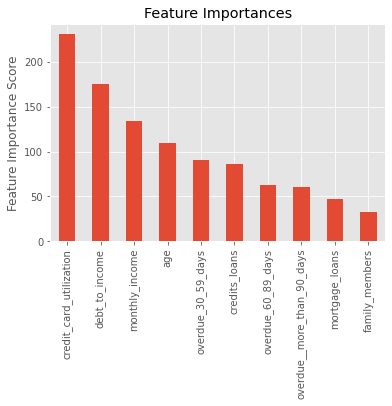

In [84]:
xgb3 = XGBClassifier(
        learning_rate=0.1,     
        n_estimators=150,   
        max_depth=3,
        min_child_weight=4,
        gamma=0.6,
        subsample=0.6,
        colsample_bytree=0.8,
        reg_alpha=1,
        objective= 'binary:logistic',
        nthread=4,
        scale_pos_weight=1,
        seed=42)
modelfit(xgb3, tr, val, predictors)


Model Report
Accuracy : 0.9358
AUC Score (Train): 0.843901
AUC Score (Test): 0.844243


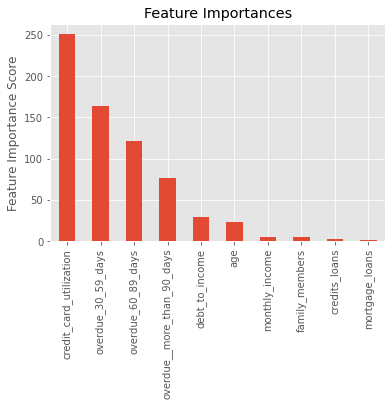

In [85]:
xgb4 = XGBClassifier(
        learning_rate=0.01,     
        n_estimators=1500,   
        max_depth=3,
        min_child_weight=4,
        gamma=0.6,
        subsample=0.6,
        colsample_bytree=0.8,
        reg_alpha=1,
        objective= 'binary:logistic',
        nthread=4,
        scale_pos_weight=1,
        seed=42)
modelfit(xgb4, tr, val, predictors)

In [86]:
X_test_prob = test.drop('index_x', axis=1)
X_test_prob

,credit_card_utilization,age,overdue_30_59_days,debt_to_income,monthly_income,credits_loans,overdue__more_than_90_days,mortgage_loans,overdue_60_89_days,family_members,target
0,-3.859946,60,0,-1.687901,9.575241,9,0,1,0,0.0,0.226834
1,-4.606665,79,0,-0.806845,8.820047,6,0,3,0,0.0,0.252293
2,-0.625140,43,1,-0.900621,8.452352,14,0,2,0,3.0,0.592295
3,-2.970770,31,0,-1.165094,8.260280,8,0,0,0,1.0,0.697950
4,-2.666073,45,0,-1.220930,9.197181,6,0,1,0,2.0,0.672565
...,...,...,...,...,...,...,...,...,...,...,...
38871,-0.312330,39,0,-1.382282,8.153319,5,0,0,0,0.0,0.966995
38872,-4.513627,70,0,-1.880337,8.335774,14,0,1,0,0.0,0.161772
38873,-2.469684,52,0,1.609438,8.723329,15,0,2,0,0.0,0.077566
38874,-0.298788,51,0,-0.971919,8.601802,9,0,2,0,0.0,0.671349


In [87]:
test

,credit_card_utilization,age,overdue_30_59_days,debt_to_income,monthly_income,credits_loans,overdue__more_than_90_days,mortgage_loans,overdue_60_89_days,family_members,index_x,target
0,-3.859946,60,0,-1.687901,9.575241,9,0,1,0,0.0,143522.0,0.226834
1,-4.606665,79,0,-0.806845,8.820047,6,0,3,0,0.0,116747.0,0.252293
2,-0.625140,43,1,-0.900621,8.452352,14,0,2,0,3.0,66075.0,0.592295
3,-2.970770,31,0,-1.165094,8.260280,8,0,0,0,1.0,133292.0,0.697950
4,-2.666073,45,0,-1.220930,9.197181,6,0,1,0,2.0,83134.0,0.672565
...,...,...,...,...,...,...,...,...,...,...,...,...
38871,-0.312330,39,0,-1.382282,8.153319,5,0,0,0,0.0,44475.0,0.966995
38872,-4.513627,70,0,-1.880337,8.335774,14,0,1,0,0.0,103189.0,0.161772
38873,-2.469684,52,0,1.609438,8.723329,15,0,2,0,0.0,48732.0,0.077566
38874,-0.298788,51,0,-0.971919,8.601802,9,0,2,0,0.0,135410.0,0.671349


In [88]:
submisstion = pd.DataFrame()
submisstion['index'] = y_test['index_x']
submisstion['index'] = submisstion['index'].astype('int')
submisstion['target'] = xgb3.predict_proba(X_test_prob[predictors])[:,1]

In [89]:
submisstion.to_csv('./submisstion_3.csv', index=False)

#### Kaggle показал score 0.86519 (то есть если в лидерборде соревнования это был бы 3 результат)

In [90]:
val['predprob'] = xgb3.predict_proba(val[predictors])[:,1]
print('AUC Score (Test): %f' % roc_auc_score(val['target'], val['predprob']))

AUC Score (Test): 0.865678


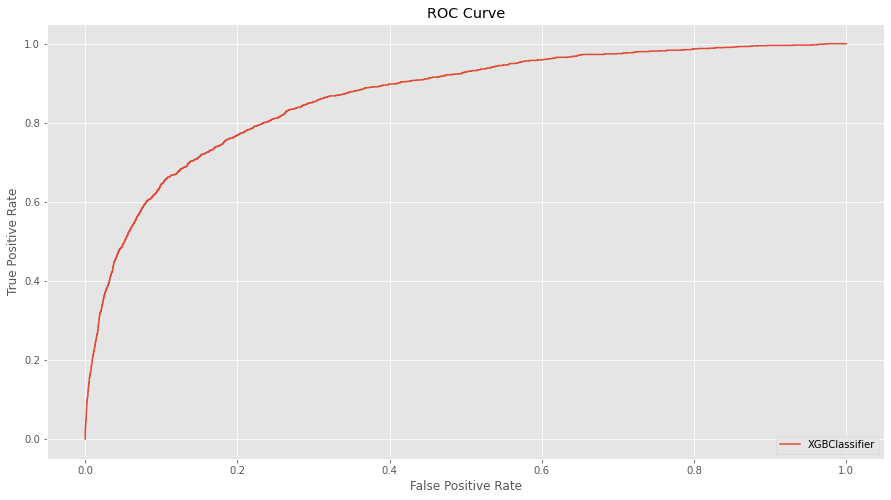

In [91]:
XGB_model = gsearch5.best_estimator_

fig = plt.figure(figsize=(15,8))

ax = fig.add_subplot(1,1,1)
ax.set_xlim([-0.05,1.05])
ax.set_ylim([-0.05,1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curve')
    
for model in [XGB_model]:
    
    scores = model.predict_proba(Xval)[:, 1]
    
    tpr, fpr, _ = roc_curve(yval, scores)
    
    ax.plot(tpr,fpr,label=model.__class__.__name__)

ax.legend(loc='lower right')
                                          
plt.show()

### Metrics

In [93]:
scaler = StandardScaler(with_mean=True, with_std=True)
Xtr_s = scaler.fit_transform(Xtr.loc[:, ['credit_card_utilization', 'age', 'debt_to_income', 'monthly_income']])
Xval_s = scaler.transform(Xval.loc[:, ['credit_card_utilization', 'age', 'debt_to_income', 'monthly_income']])

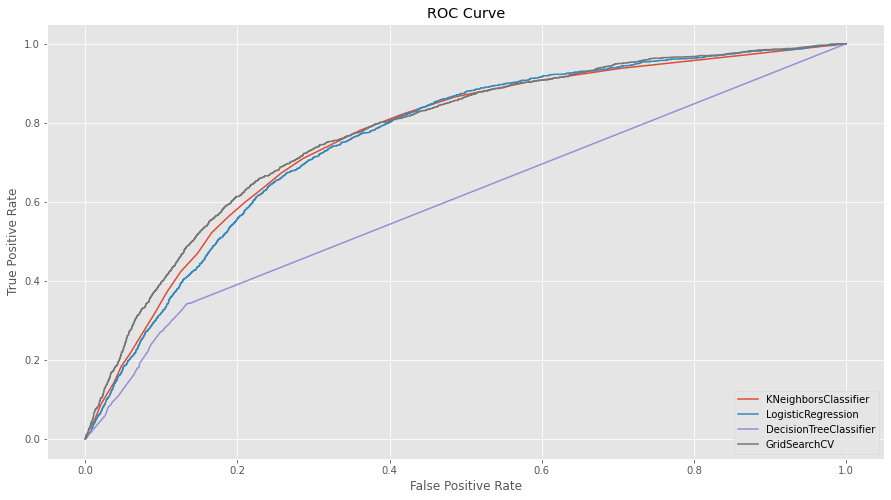

In [94]:
fig = plt.figure(figsize=(15,8))

ax = fig.add_subplot(1,1,1)
ax.set_xlim([-0.05,1.05])
ax.set_ylim([-0.05,1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curve')
    
for model in [kNN_model, LR_model, DT_model, grid_forest]:
    
    scores = model.predict_proba(Xval_s)[:, 1]
    tpr, fpr, _ = roc_curve(yval, scores)
    
    ax.plot(tpr,fpr,label=model.__class__.__name__)

ax.legend(loc='lower right')
                                          
plt.show()

In [95]:
for model in [GS_LR, GS_kNN, GS_dtc, grid_forest]: 
    y_pred = (model.predict_proba(Xval_s)[:, 1] > 0.07) * 1
    a = confusion_matrix(yval, y_pred)
    tp = a[0][0] 
    fp = a[0][1] 
    fn = a[1][0] 
    tn = a[1][1] 
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    f1 = (2*precision*recall)/(precision + recall)
    print(f'Results of the {model}: precision - {precision}; recall - {recall}; f1 - {f1}')
    print(confusion_matrix(yval, y_pred))

Results of the GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
             estimator=LogisticRegression(),
             param_grid={'C': array([1.0000e-07, 2.3357e-07, 5.4556e-07, 1.2743e-06, 2.9764e-06,
       6.9519e-06, 1.6238e-05, 3.7927e-05, 8.8587e-05, 2.0691e-04,
       4.8329e-04, 1.1288e-03, 2.6367e-03, 6.1585e-03, 1.4384e-02,
       3.3598e-02, 7.8476e-02, 1.8330e-01, 4.2813e-01, 1.0000e+00])},
             scoring='roc_auc'): precision - 0.6130527817403709; recall - 0.9762291092000649; f1 - 0.7531451461475872
[[12033  7595]
 [  293  1101]]
Results of the GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
             estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': range(1, 100, 5)}, scoring='roc_auc'): precision - 0.6797941715916038; recall - 0.9737283806465737; f1 - 0.8006360445231165
[[13343  6285]
 [  360  1034]]
Results of the GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None,

In [96]:
for model in [XGB_model]: 
    y_pred = (model.predict_proba(Xval)[:, 1] > 0.07) * 1
    a = confusion_matrix(yval, y_pred)
    tp = a[0][0] 
    fp = a[0][1] 
    fn = a[1][0] 
    tn = a[1][1] 
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    f1 = (2*precision*recall)/(precision + recall)
    print(f'Results of the {model}: precision - {precision}; recall - {recall}; f1 - {f1}')
    print(confusion_matrix(yval, y_pred))

Results of the XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8,
              enable_categorical=False, gamma=0.6, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=4, missing=nan, monotone_constraints='()',
              n_estimators=150, n_jobs=4, nthread=4, num_parallel_tree=1,
              predictor='auto', random_state=42, reg_alpha=0.01, reg_lambda=1,
              scale_pos_weight=1, seed=42, subsample=0.6, tree_method='exact',
              validate_parameters=1, verbosity=None): precision - 0.8025779498675362; recall - 0.9796641791044776; f1 - 0.8823232888988463
[[15753  3875]
 [  327  1067]]


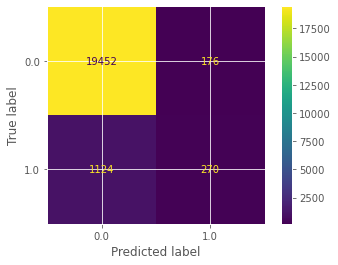

In [97]:
plot_confusion_matrix(XGB_model, Xval, yval)